<a href="https://colab.research.google.com/github/gRedDeer/kaggle_notebooks/blob/main/Loan_Approval_Prediction_mult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


In [142]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from sklearn.pipeline import Pipeline
import gc
from xgboost import XGBClassifier, DMatrix, plot_importance
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, plot_importance
from lightgbm.callback import early_stopping
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBRFClassifier
from sklearn.linear_model import Ridge

In [144]:
train_df = pd.read_csv('Loan Approval Prediction/train.csv', index_col='id')
test_df = pd.read_csv('Loan Approval Prediction/test.csv', index_col='id')
orig_df = pd.read_csv('Loan Approval Prediction/credit_risk_dataset.csv')

In [145]:
orig_df.index
train_df = pd.concat([train_df, orig_df])
train_df = train_df.reset_index(drop=True)
train_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [146]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91226 entries, 0 to 91225
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 8.4+ MB


In [147]:
train_df.isna().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,895
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_percent_income,0
cb_person_default_on_file,0


In [148]:
train_df['loan_int_rate'] = train_df['loan_int_rate'].fillna(train_df['loan_int_rate'].mean())
train_df['person_emp_length'] = train_df['person_emp_length'].fillna(train_df['person_emp_length'].mean())

In [166]:
#MAGIC
for df in [train_df, test_df]:
  df['partial_net_worth'] = df['person_income'] * df['person_emp_length']
  df['monthly_debt'] = (df['loan_amnt'] * (1 + df['loan_int_rate'].astype(float)) / 12)
  #df['monthly_income'] = (df['person_income'])/12

In [150]:
target = train_df['loan_status']
features = train_df.drop('loan_status', axis=1).columns.tolist()

In [151]:
cat_features = train_df.select_dtypes(include='object').columns.tolist()
num_features = list(set(features) - set(cat_features))

In [152]:
train_df.describe(include='all').T.sort_values(by='unique')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cb_person_default_on_file,91226,2,N,76779,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_home_ownership,91226,4,RENT,47040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_intent,91226,6,EDUCATION,18724,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_grade,91226,7,A,31761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_age,91226.0,NaN,NaN,NaN,27.61648,6.148115,20.0,23.0,26.0,30.0,144.0
person_income,91226.0,NaN,NaN,NaN,64770.706224,47936.961097,4000.0,40000.0,57000.0,78000.0,6000000.0
person_emp_length,91226.0,NaN,NaN,NaN,4.732119,4.005274,0.0,2.0,4.0,7.0,123.0
loan_amnt,91226.0,NaN,NaN,NaN,9350.348607,5848.605423,500.0,5000.0,8000.0,12000.0,35000.0
loan_int_rate,91226.0,NaN,NaN,NaN,10.789508,3.055439,5.42,7.88,10.789508,12.99,23.22
loan_percent_income,91226.0,NaN,NaN,NaN,0.163154,0.097491,0.0,0.09,0.14,0.22,0.83


In [153]:
for col in cat_features:
    display(train_df.groupby(col)[['loan_amnt', 'loan_int_rate']].agg(['min', 'mean', 'max']))

loan_amnt                      loan_int_rate             \
                            min          mean    max           min       mean   
person_home_ownership                                                           
MORTGAGE                    500  10177.988136  35000          5.42  10.154897   
OTHER                      1000  10599.617347  25000          5.79  11.735222   
OWN                         900   8871.172667  35000          5.42  10.773927   
RENT                        500   8730.129188  35000          5.42  11.303732   

                              
                         max  
person_home_ownership         
MORTGAGE               22.48  
OTHER                  20.52  
OWN                    21.27  
RENT                   23.22

loan_amnt                      loan_int_rate             \
                        min          mean    max           min       mean   
loan_intent                                                                 
DEBTCONSOLIDATION       500   9311.842105  35000          5.42  10.740802   
EDUCATION               700   9200.219344  35000          5.42  10.768989   
HOMEIMPROVEMENT         500  10273.793121  35000          5.42  10.985154   
MEDICAL                 500   8976.930315  35000          5.42  10.846264   
PERSONAL                500   9358.476540  35000          5.42  10.739256   
VENTURE                 500   9379.518436  35000          5.42  10.723682   

                          
                     max  
loan_intent               
DEBTCONSOLIDATION  22.11  
EDUCATION          21.74  
HOMEIMPROVEMENT    23.22  
MEDICAL            21.74  
PERSONAL           22.06  
VENTURE            23.22

loan_amnt                      loan_int_rate                  
                 min          mean    max           min       mean    max
loan_grade                                                               
A                500   8478.378357  35000      5.420000   7.441947  19.04
B                500   9748.841431  35000      5.990000  11.014408  17.56
C                500   9085.190637  35000      5.790000  13.396767  16.29
D               1000  10658.709007  35000      6.000000  15.221815  19.13
E               1000  12537.645717  35000      6.000000  16.707653  23.06
F               1200  13997.756410  35000     10.789508  18.068479  22.06
G               1500  15618.298969  35000     10.789508  19.789665  23.22

loan_amnt                     loan_int_rate  \
                                min         mean    max           min   
cb_person_default_on_file                                               
N                               500  9276.934865  35000          5.42   
Y                               750  9740.508064  35000          5.99   

                                             
                                mean    max  
cb_person_default_on_file                    
N                          10.135789  21.74  
Y                          14.263717  23.22

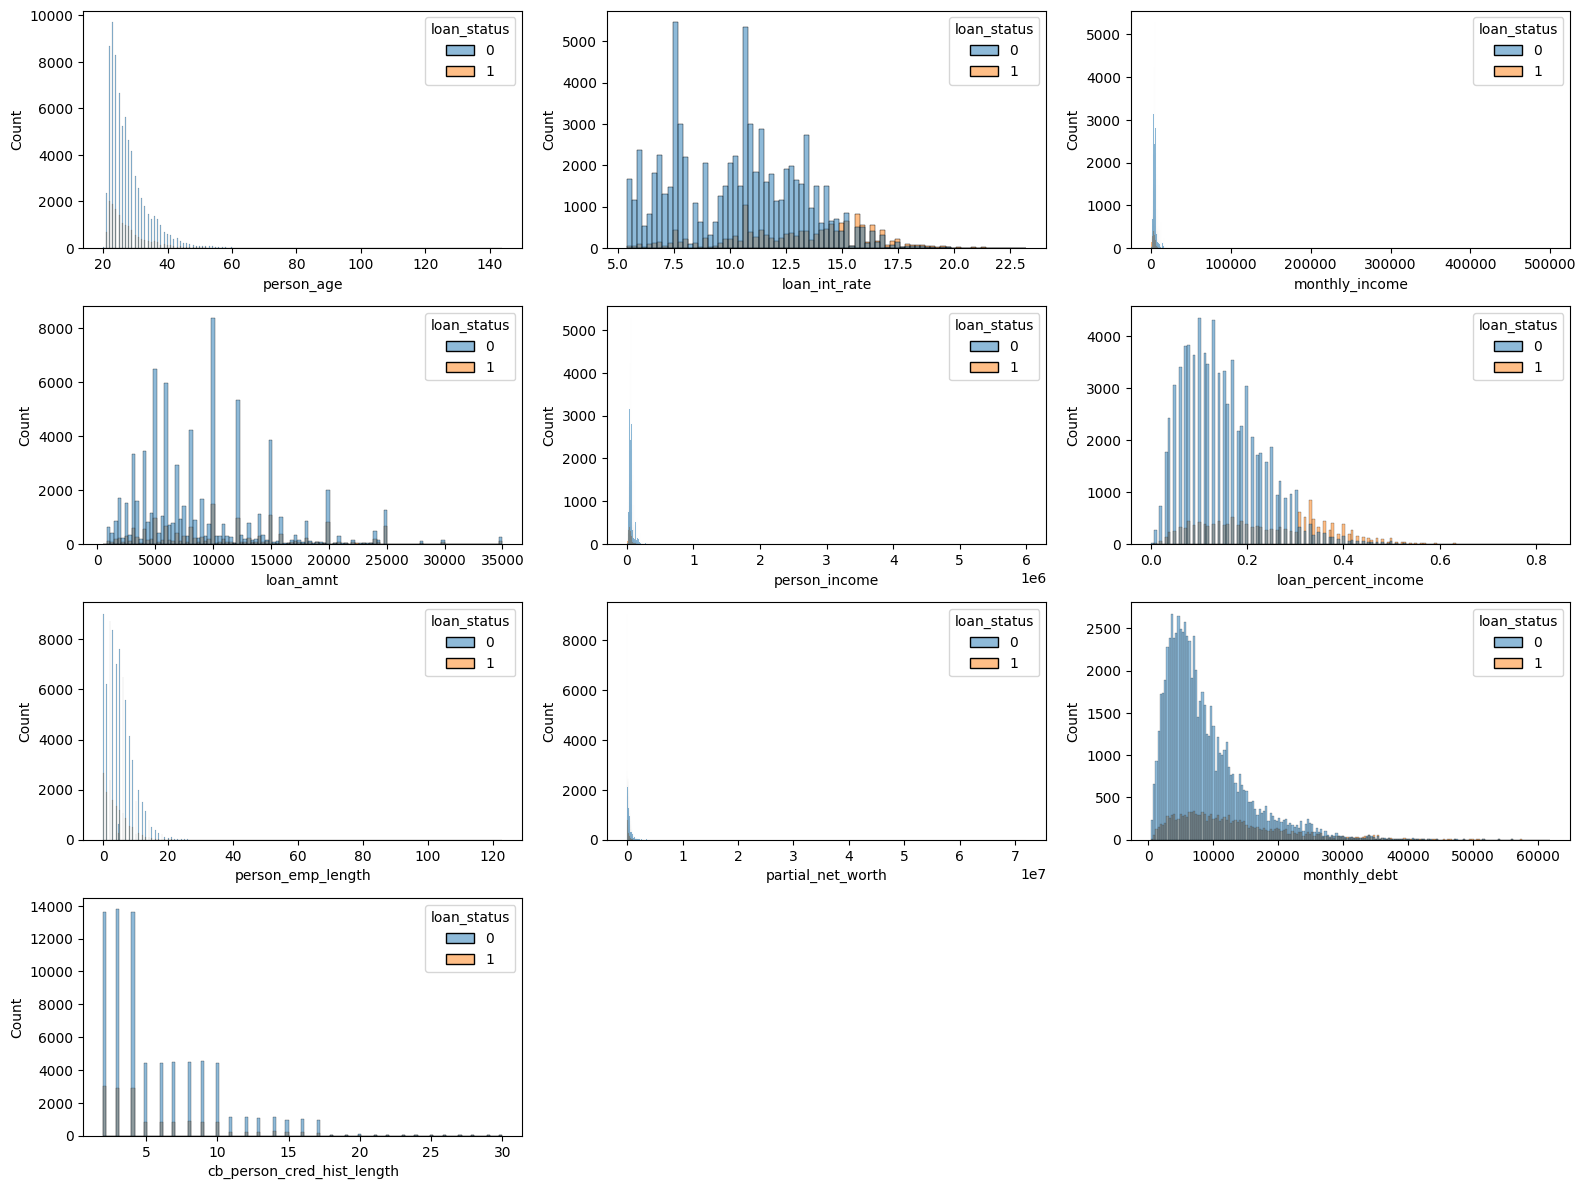

In [156]:
plt.figure(figsize=(16, 12))

for i,col in enumerate(num_features):
  plt.subplot(4,3,i+1)
  sns.histplot(train_df, x=col, hue=target)

plt.tight_layout()
plt.show()

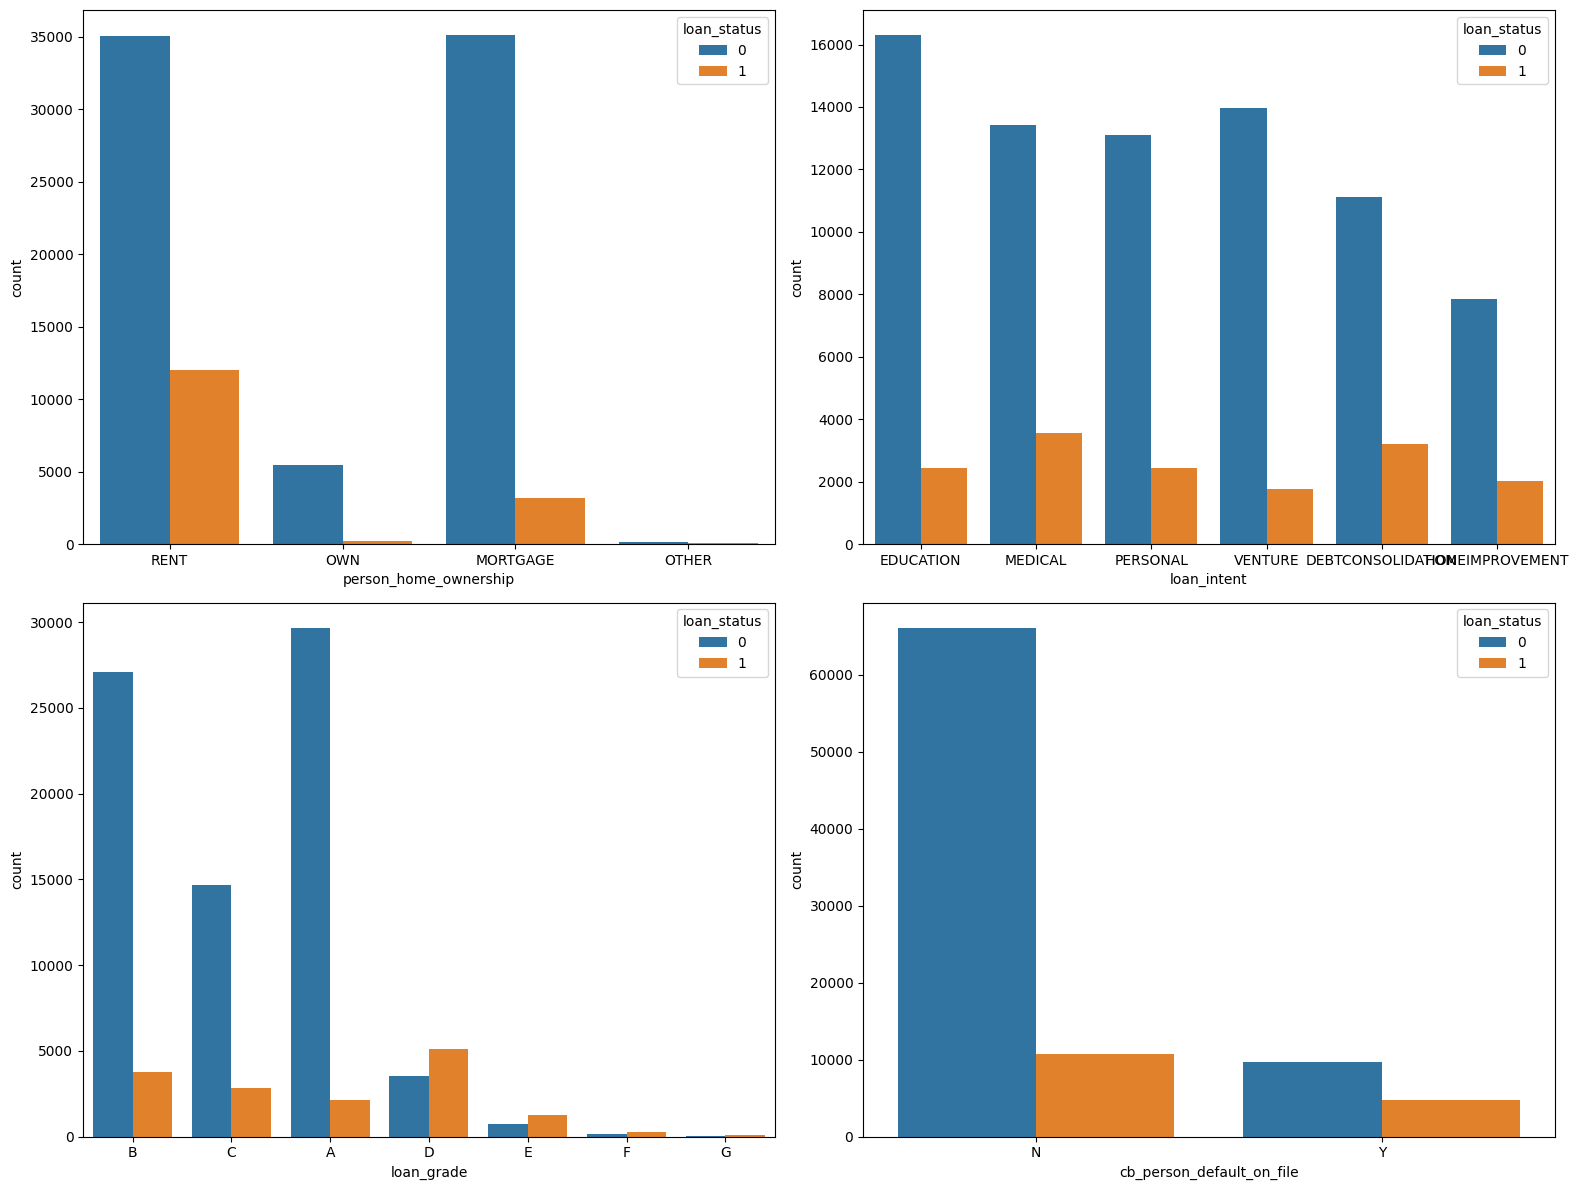

In [157]:
plt.figure(figsize=(16, 12))

for i,col in enumerate(cat_features):
  plt.subplot(2,2,i+1)
  sns.countplot(train_df, x=col, hue=target)

plt.tight_layout()
plt.show()

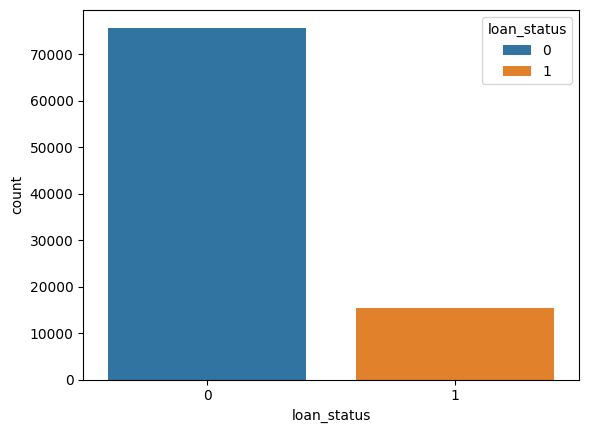

In [158]:
sns.countplot(train_df, x=target, hue=target)
plt.show()

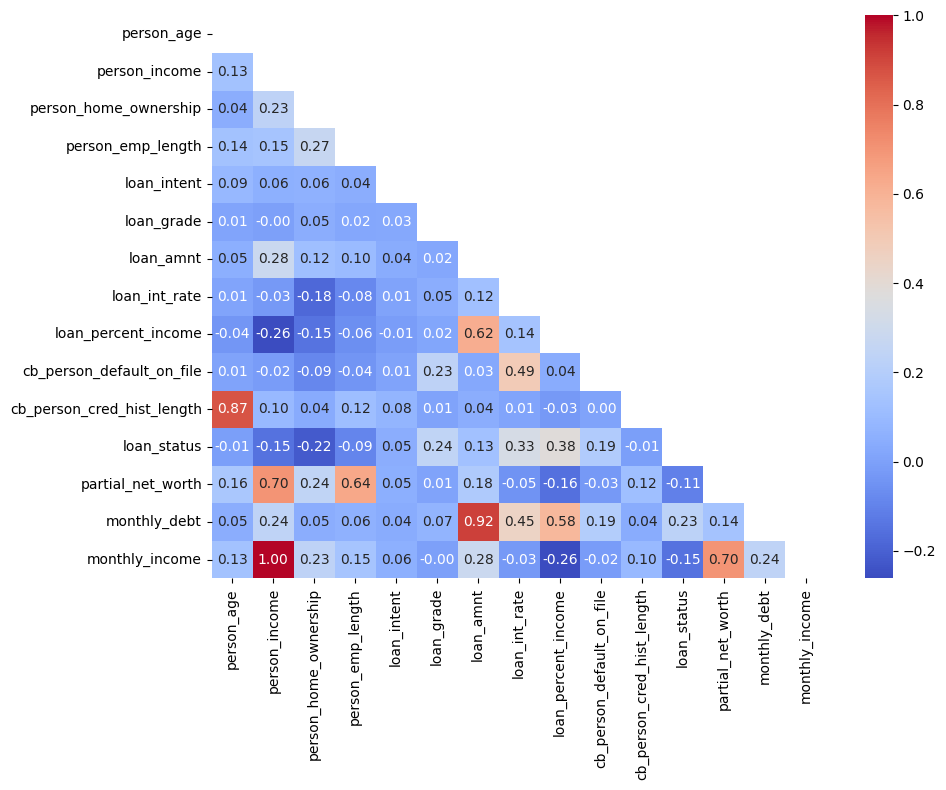

In [159]:
train_new = train_df.copy()

for col in cat_features:
    train_new[col], _ = train_new[col].factorize()

cor_mat = train_new.corr()
mask = np.triu(cor_mat)

plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat, fmt='.2f', annot=True, mask=mask, cmap='coolwarm')
plt.tight_layout()
plt.show()

In [160]:
def model_trainer(model, X, y, test, n_splits=10, random_state=42):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    roc_aucs = []
    test_pred = np.zeros(len(test))
    oof_train_preds = np.zeros(len(y))

    model_name = model[-1].__class__.__name__ if isinstance(model, Pipeline) else model.__class__.__name__

    print("="*72)
    print(f"Training {model_name}")
    print("="*72,sep='\n')

    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        try:
            y_pred_proba = model_clone.predict_proba(X_test)[:,1]
            test_pred += model_clone.predict_proba(test)[:, 1]
        except:
            y_pred_proba = model_clone.predict(X_test)
            test_pred += model_clone.predict(test)
        oof_train_preds[test_idx] = y_pred_proba
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        roc_aucs.append(roc_auc)
        print(f"Fold {fold+1} --> ROC_AUC Score: {roc_auc:.6f}")

        del model_clone, X_train, X_test, y_train, y_test
        gc.collect()

    print(f"\nAverage Fold ROC_AUC Score: {np.mean(roc_aucs):.6f} \xb1 {np.std(roc_aucs):.6f}\n")
    return test_pred/skfold.get_n_splits(), oof_train_preds

In [161]:
def convert_to_string(df):
    df_cat = df.copy()
    df_cat = df_cat.fillna(0)
    for col in features:
        df_cat[col] = df_cat[col].astype('string')
    return df_cat

In [162]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [163]:
X = train_df.drop('loan_status', axis=1)
y = target.ravel()

In [164]:
train_preds = {}
test_preds = {}

In [180]:
# Initialize a variable to store one model for feature importance plotting
best_xgb_model = None

X_xgb = X.copy()
X_xgb[cat_features] = X_xgb[cat_features].astype('category')

test_xgb = test_df.copy()
test_xgb[cat_features] = test_xgb[cat_features].astype('category')

oof_preds = []
oof_aucs = []
oof_train_preds = np.zeros(len(y))


xgb_params = {
    'eval_metric': 'auc',
    'n_estimators': 5000,
    'learning_rate': 0.10999995057648126,
    'max_depth': 8,
    'subsample': 0.9999999999999999,
    'colsample_bytree': 0.49681888251576845,
    'reg_alpha': 8.919028743833996e-06,
    'reg_lambda': 9.999999999999998,
    'gamma': 0.09787383664032377,
    'min_child_weight': 1.0,
    'max_bin': 262143,
#     'tree_method': 'hist',
    'device': 'cuda',
    'enable_categorical': True,
    'early_stopping_rounds': 100,
}

for fold, (train_idx, test_idx) in enumerate(skfold.split(X_xgb, y)):
    X_train, y_train = X_xgb.iloc[train_idx], y[train_idx]
    X_test, y_test = X_xgb.iloc[test_idx], y[test_idx]

    xgb_clf = XGBClassifier(**xgb_params)
    xgb_clf = xgb_clf.fit(X_train, y_train,
                          eval_set=[(X_test, y_test)],
                          verbose=0)
    # Store the best model from any fold for later use (you can adjust this logic as needed)
    if best_xgb_model is None or xgb_clf.best_score > auc:
      best_xgb_model = xgb_clf

    booster = xgb_clf.get_booster()
    oof_train_preds[test_idx] = booster.predict(DMatrix(X_test, enable_categorical=True),
                                               iteration_range=(0, xgb_clf.best_iteration + 1))
    test_pred = booster.predict(DMatrix(test_xgb, enable_categorical=True),
                                iteration_range=(0, xgb_clf.best_iteration + 1))
    auc = xgb_clf.best_score
    oof_aucs.append(auc)
    oof_preds.append(test_pred)
    print(f"Fold {fold+1} --> ROC-AUC Score: {auc:.6f}")

    del X_train, y_train, X_test, y_test, xgb_clf
    gc.collect()

# After cross-validation, plot feature importance using the saved model
plt.figure(figsize=(6, 4))
plot_importance(best_xgb_model, importance_type='gain', max_num_features=10)  # Change importance_type if needed
plt.title('Top 10 Feature Importance')
plt.tight_layout
plt.show()

auc_mean = np.mean(oof_aucs)
auc_std = np.std(oof_aucs)
print(f"\nAverage Fold ROC-AUC Score: {auc_mean:.6f} \xB1 {auc_std:.6f}\n")

train_preds['xgb'] = oof_train_preds
test_pred_xgb = np.mean(oof_preds, axis=0)
test_preds['xgb'] = test_pred_xgb

Fold 1 --> ROC-AUC Score: 0.963703
Fold 2 --> ROC-AUC Score: 0.966048
Fold 3 --> ROC-AUC Score: 0.962847
Fold 4 --> ROC-AUC Score: 0.963447
Fold 5 --> ROC-AUC Score: 0.958160
Fold 6 --> ROC-AUC Score: 0.964089
Fold 7 --> ROC-AUC Score: 0.962631
Fold 8 --> ROC-AUC Score: 0.953513
Fold 9 --> ROC-AUC Score: 0.963671
Fold 10 --> ROC-AUC Score: 0.958864

Average Fold ROC-AUC Score: 0.961697 ± 0.003540



In [186]:
# Variables to store out-of-fold (OOF) predictions and feature importances
oof_preds = []
oof_aucs = []
oof_train_preds = np.zeros(len(y))
feature_importance_df = pd.DataFrame()  # DataFrame to store feature importances

cat_params = {
    'task_type': "GPU",
    'loss_function': 'Logloss',
    #'eval_metric': "AUC",
    # For evaluation, switch to CPU for AUC
    'eval_metric': 'AUC:hints=skip_train~true',  # CPU evaluation for AUC
    'bagging_temperature': 0.25,
    'iterations': 5000,
    'learning_rate': 0.045,
    'max_depth': 7,
    'l2_leaf_reg': 0.80,
    'min_data_in_leaf': 30,
    'random_strength': 0.25,
    'random_state': 42,
    'early_stopping_rounds': 200,
    'use_best_model': True,
    'allow_writing_files': False,
}

X_cat = convert_to_string(X)
test_cat = convert_to_string(test_df)

test_pool = Pool(test_cat, cat_features=features)

# Initialize to store one model for feature importance
best_cat_clf = None

for fold, (train_idx, test_idx) in enumerate(skfold.split(X_cat, y)):
    X_train, y_train = X_cat.iloc[train_idx], y[train_idx]
    X_test, y_test = X_cat.iloc[test_idx], y[test_idx]

    X_train_pool = Pool(X_train, y_train, cat_features=features)
    X_test_pool = Pool(X_test, y_test, cat_features=features)

    cat_clf = CatBoostClassifier(**cat_params)
    cat_clf = cat_clf.fit(X=X_train_pool, eval_set=X_test_pool, verbose=0, early_stopping_rounds=200)

    # Out-of-fold predictions
    oof_train_preds[test_idx] = cat_clf.predict_proba(Pool(X_test, cat_features=features))[:, 1]
    test_pred = cat_clf.predict_proba(test_pool)[:, 1]

    # Save feature importance for this fold
    fold_importance = cat_clf.get_feature_importance(Pool(X_test, cat_features=features))

    # Store fold importances in a DataFrame
    fold_importance_df = pd.DataFrame({
        'feature': features,
        f'importance_fold_{fold + 1}': fold_importance
    })
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=1)

    oof_preds.append(test_pred)
    auc = cat_clf.best_score_['validation']['AUC']
    oof_aucs.append(auc)
    print(f"\nFold {fold+1} --> ROC-AUC Score: {auc:.6f}\n")

    # Save the best model for feature importance
    if best_cat_clf is None or auc > max(oof_aucs):
        best_cat_clf = cat_clf

    del X_train, y_train, X_test, y_test
    del X_train_pool, X_test_pool
    del cat_clf
    gc.collect()

# Calculate the mean feature importance across folds
feature_importance_df['mean_importance'] = feature_importance_df.filter(like='importance_fold').mean(axis=1)
# Drop duplicate 'feature' columns
# Plot the top 10 important features
top_features_1 = top_features.loc[:, ~top_features.columns.duplicated()]
plt.figure(figsize=(5, 3))
sns.barplot(x='mean_importance', y='feature', data=top_features_1)
plt.title('Top 10 Feature Importance (CatBoost)')
plt.show()

# Average and standard deviation of AUCs
auc_mean = np.mean(oof_aucs)
auc_std = np.std(oof_aucs)
print(f"\nAverage Fold ROC-AUC Score: {auc_mean:.6f} ± {auc_std:.6f}\n")

train_preds['cat'] = oof_train_preds
test_pred_cat = np.mean(oof_preds, axis=0)
test_preds['cat'] = test_pred_cat

Default metric period is 5 because AUC is/are not implemented for GPU



Fold 1 --> ROC-AUC Score: 0.970790



Default metric period is 5 because AUC is/are not implemented for GPU



Fold 2 --> ROC-AUC Score: 0.969602



Default metric period is 5 because AUC is/are not implemented for GPU



Fold 3 --> ROC-AUC Score: 0.969339



Default metric period is 5 because AUC is/are not implemented for GPU



Fold 4 --> ROC-AUC Score: 0.968222



Default metric period is 5 because AUC is/are not implemented for GPU



Fold 5 --> ROC-AUC Score: 0.966207



Default metric period is 5 because AUC is/are not implemented for GPU



Fold 6 --> ROC-AUC Score: 0.968770



Default metric period is 5 because AUC is/are not implemented for GPU



Fold 7 --> ROC-AUC Score: 0.969307



Default metric period is 5 because AUC is/are not implemented for GPU



Fold 8 --> ROC-AUC Score: 0.963073



Default metric period is 5 because AUC is/are not implemented for GPU



Fold 9 --> ROC-AUC Score: 0.968698



Default metric period is 5 because AUC is/are not implemented for GPU



Fold 10 --> ROC-AUC Score: 0.964159


Average Fold ROC-AUC Score: 0.967817 ± 0.002385



ValueError: 2

<Figure size 1000x600 with 0 Axes>

In [192]:
X_xgb = X.copy()
X_xgb[cat_features] = X_xgb[cat_features].astype('category')

test_xgb = test_df.copy()
test_xgb[cat_features] = test_xgb[cat_features].astype('category')

oof_preds = []
oof_aucs = []
oof_train_preds = np.zeros(len(y))

lgb_params = {
    'n_estimators': 3000,
    "verbosity": -1,
    'depth': 15,
    "eval_metric": "auc",
    "max_bin": 262143,
    'num_leaves': 223,
    'learning_rate': 0.01,
    'min_child_samples': 54,
    'subsample': 0.5395472919165504,
    'colsample_bytree': 0.547518064129546,
    'lambda_l1': 3.4444245446562,
    'lambda_l2': 2.87490408088595e-05,
    'enable_categorical': True,
}

# Keep track of feature importance
feature_importances = np.zeros(X_xgb.shape[1])

for fold, (train_idx, test_idx) in enumerate(skfold.split(X_xgb, y)):
    X_train, y_train = X_xgb.iloc[train_idx], y[train_idx]
    X_test, y_test = X_xgb.iloc[test_idx], y[test_idx]

    lgb_clf = LGBMClassifier(**lgb_params)
    lgb_clf = lgb_clf.fit(X_train, y_train,
                          eval_set=[(X_test, y_test)],
                          eval_metric='auc',
                          callbacks=[early_stopping(100)])

    y_pred = lgb_clf.predict_proba(X_test, num_iteration=lgb_clf.best_iteration_)[:,1]
    auc = roc_auc_score(y_test, y_pred)
    oof_aucs.append(auc)
    oof_train_preds[test_idx] = y_pred
    oof_preds.append(lgb_clf.predict_proba(test_xgb, num_iteration=lgb_clf.best_iteration_)[:,1])
    print(f"\nFold {fold+1} --> ROC-AUC Score: {auc:.6f}\n")

    # Accumulate feature importance
    feature_importances += lgb_clf.feature_importances_

    del X_train, y_train, X_test, y_test, lgb_clf
    gc.collect()

# Calculate average feature importance
feature_importances /= len(skfold.split(X_xgb, y))

# Assuming `feature_importances` and the feature names are available
features = X_xgb.columns
feature_importances_df = pd.DataFrame({
    'feature': features,
    'mean_importance': feature_importances
})
# Sort by mean importance
top_features = feature_importances_df.sort_values(by='mean_importance', ascending=False).head(20)
# Plotting
plt.figure(figsize=(6, 4))
plt.barh(top_features['feature'], top_features['mean_importance'], color='skyblue')
plt.xlabel('Mean Importance')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

# Average AUC
auc_mean = np.mean(oof_aucs)
auc_std = np.std(oof_aucs)
print(f"\n\nAverage Fold ROC-AUC Score: {auc_mean:.6f} ± {auc_std:.6f}\n\n")

train_preds['lgb'] = oof_train_preds
test_pred_lgb = np.mean(oof_preds, axis=0)
test_preds['lgb'] = test_pred_lgb


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1372]	valid_0's auc: 0.962943	valid_0's binary_logloss: 0.152605

Fold 1 --> ROC-AUC Score: 0.962943

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1219]	valid_0's auc: 0.965129	valid_0's binary_logloss: 0.144073

Fold 2 --> ROC-AUC Score: 0.965129

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1270]	valid_0's auc: 0.962665	valid_0's binary_logloss: 0.150195

Fold 3 --> ROC-AUC Score: 0.962665

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1311]	valid_0's auc: 0.963783	valid_0's binary_logloss: 0.153256

Fold 4 --> ROC-AUC Score: 0.963783

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1207]	valid_0's auc: 0.95651	valid_0's binary_logloss: 0.159776

Fold 5 --> ROC-AUC Score: 0.956510

T

TypeError: object of type 'generator' has no len()

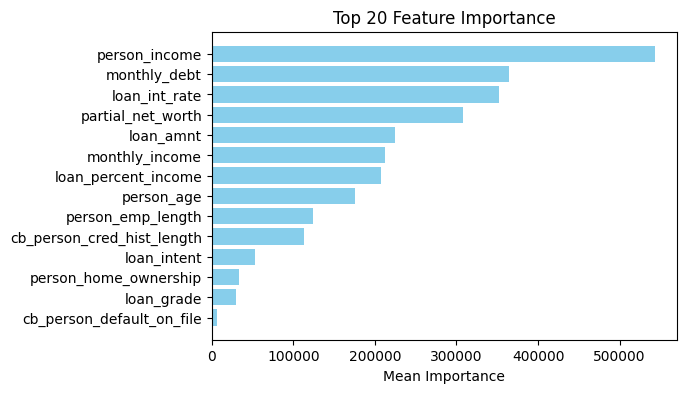

In [196]:
# Assuming `feature_importances` and the feature names are available
features = X_xgb.columns
feature_importances_df = pd.DataFrame({
    'feature': features,
    'mean_importance': feature_importances
})

# Sort by mean importance
top_features = feature_importances_df.sort_values(by='mean_importance', ascending=False).head(20)

# Plotting
plt.figure(figsize=(6, 4))
plt.barh(top_features['feature'], top_features['mean_importance'], color='skyblue')
plt.xlabel('Mean Importance')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

In [202]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_oe = X.copy()
X_oe[cat_features] = oe.fit_transform(X_oe[cat_features])
test_oe = test_df.copy()
test_oe[cat_features] = oe.transform(test_oe[cat_features])

hgb_clf = HistGradientBoostingClassifier()
test_preds['hgb'], train_preds['hgb'] = model_trainer(hgb_clf, X_oe, y, test_oe, random_state=101)

Training HistGradientBoostingClassifier
Fold 1 --> ROC_AUC Score: 0.953707
Fold 2 --> ROC_AUC Score: 0.958415
Fold 3 --> ROC_AUC Score: 0.954444
Fold 4 --> ROC_AUC Score: 0.953625
Fold 5 --> ROC_AUC Score: 0.954723
Fold 6 --> ROC_AUC Score: 0.950230
Fold 7 --> ROC_AUC Score: 0.952429
Fold 8 --> ROC_AUC Score: 0.950404
Fold 9 --> ROC_AUC Score: 0.951115
Fold 10 --> ROC_AUC Score: 0.950615

Average Fold ROC_AUC Score: 0.952971 ± 0.002434



In [203]:
xgbrf_clf = XGBRFClassifier()

test_preds['rf'], train_preds['rf'] = model_trainer(xgbrf_clf, X_oe, y, test_oe, random_state=101)

Training XGBRFClassifier
Fold 1 --> ROC_AUC Score: 0.914914
Fold 2 --> ROC_AUC Score: 0.915691
Fold 3 --> ROC_AUC Score: 0.914319
Fold 4 --> ROC_AUC Score: 0.919098
Fold 5 --> ROC_AUC Score: 0.921582
Fold 6 --> ROC_AUC Score: 0.912018
Fold 7 --> ROC_AUC Score: 0.913002
Fold 8 --> ROC_AUC Score: 0.915896
Fold 9 --> ROC_AUC Score: 0.922717
Fold 10 --> ROC_AUC Score: 0.913090

Average Fold ROC_AUC Score: 0.916233 ± 0.003504



In [204]:
test_preds_df = pd.DataFrame(test_preds)
train_preds_df = pd.DataFrame(train_preds)

In [205]:
test_preds_df.shape, train_preds_df.shape

((39098, 4), (91226, 4))

In [206]:
ridge = Ridge(positive=True, tol=1e-6)

ridge_pred_stack, _ = model_trainer(ridge, train_preds_df, y, test_preds_df,random_state=101)

Training Ridge
Fold 1 --> ROC_AUC Score: 0.967604
Fold 2 --> ROC_AUC Score: 0.971622
Fold 3 --> ROC_AUC Score: 0.968302
Fold 4 --> ROC_AUC Score: 0.970749
Fold 5 --> ROC_AUC Score: 0.971256
Fold 6 --> ROC_AUC Score: 0.966140
Fold 7 --> ROC_AUC Score: 0.967179
Fold 8 --> ROC_AUC Score: 0.968628
Fold 9 --> ROC_AUC Score: 0.968345
Fold 10 --> ROC_AUC Score: 0.967559

Average Fold ROC_AUC Score: 0.968739 ± 0.001758



In [208]:
from datetime import datetime
sub = pd.read_csv('Loan Approval Prediction/sample_submission.csv')
sub['loan_status'] = ridge_pred_stack
csv_str = 'Loan Approval Prediction/submission_'+ str(datetime.now().strftime('%Y_%m_%dT%H%M')) + '.csv'
sub.to_csv(csv_str, index=False)

In [209]:
!kaggle competitions submit -c playground-series-s4e10 -f "/content/gdrive/MyDrive/Kaggle/Loan Approval Prediction/submission_2024_10_19T1557.csv" -m "colab"

100% 0.99M/0.99M [00:00<00:00, 1.64MB/s]
Successfully submitted to Loan Approval Prediction

In [114]:
#mkdir ~/.kaggle

In [115]:
#mv /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json

In [116]:
#!chmod 600 ~/.kaggle/kaggle.json

In [117]:
#!kaggle competitions list